## Data Analysis Using PySpark SQL & ML

This project uses distributed query engine, Spark SQL, to analyze the 'Medical Appointment No Shows' dataset from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

**Dataset**: Medical Appointment No Shows

**Context**: Approxiamtely 30% of patients miss their scheduled appointments, is there a way to predict whether the patient will show up based on demographic and clinical variables? 

**Independet Variables**: Gender, age, appointment day, medical condition, SMS notification, etc

**Dependet Variable**: Show/No-show

### Load Data

Install PySpark.

In [1]:
#!pip install pyspark

Create Spark session.

In [2]:
from pyspark.sql import SparkSession

appointment_csv = 'KaggleV2-May-2016.csv'
spark = SparkSession.builder.appName('ml-appointment').getOrCreate()
df = spark.read.csv(appointment_csv, header = True, inferSchema = True)

### Check Data

Show first 5 rows. df.show(5) can be used alternatively.

In [3]:
df.limit(5).toPandas().transpose()

,0,1,2,3,4
PatientId,2.98725e+13,5.58998e+14,4.26296e+12,8.67951e+11,8.84119e+12
AppointmentID,5642903,5642503,5642549,5642828,5642494
Gender,F,M,F,F,F
ScheduledDay,2016-04-29 14:38:08,2016-04-29 12:08:27,2016-04-29 12:19:04,2016-04-29 13:29:31,2016-04-29 12:07:23
AppointmentDay,2016-04-28 20:00:00,2016-04-28 20:00:00,2016-04-28 20:00:00,2016-04-28 20:00:00,2016-04-28 20:00:00
Age,62,56,62,8,56
Neighbourhood,JARDIM DA PENHA,JARDIM DA PENHA,MATA DA PRAIA,PONTAL DE CAMBURI,JARDIM DA PENHA
Scholarship,0,0,0,0,0
Hipertension,1,0,0,0,1
Diabetes,0,0,0,0,1


Print out schema in tree format.

In [4]:
df.printSchema()

root
 |-- PatientId: double (nullable = true)
 |-- AppointmentID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- ScheduledDay: timestamp (nullable = true)
 |-- AppointmentDay: timestamp (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Neighbourhood: string (nullable = true)
 |-- Scholarship: integer (nullable = true)
 |-- Hipertension: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Alcoholism: integer (nullable = true)
 |-- Handcap: integer (nullable = true)
 |-- SMS_received: integer (nullable = true)
 |-- No-show: string (nullable = true)



Get descriptive statistics.

In [5]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
PatientId,110527,1.474962657103957E14,2.560949202917392E14,39217.84439,9.99981631772427E14
AppointmentID,110527,5675305.123426855,71295.75153968473,5030230,5790484
Gender,110527,None,None,F,M
Age,110527,37.08887421173107,23.110204963682648,-1,115
Neighbourhood,110527,None,None,AEROPORTO,VILA RUBIM
Scholarship,110527,0.09826558216544373,0.2976747541093073,0,1
Hipertension,110527,0.1972459218109602,0.3979213499470851,0,1
Diabetes,110527,0.07186479321794674,0.2582650735074665,0,1
Alcoholism,110527,0.030399811810688793,0.17168555541424446,0,1


Based on the table above, we idenifited some issues in the dataset.

- **1.** The minimum age is -1.
- **2.** The column name 'Handcap' and 'Hipertension' should be 'Handicap' and 'Hypertension', respectively.
- **3.** The column type of 'Gender' and 'No-show' are strings, which can be better represented by integers 0 and 1.

### Clean Data

**1.** Remove patients with **age** <= 0 from the dataset.

In [6]:
df = df.filter(df.Age > 0)
df = df.filter(df.Age < 115)

**2.** Rename the **'Handcap'** and **'Hipertension'** columns to **'Handicap'** and **'Hypertension'**.

In [7]:
df = df.withColumnRenamed('Handcap', 'Handicap').withColumnRenamed('Hipertension', 'Hypertension')

**3.** Change the cloumn type of **'Gender'** and **'No-show'** from string to integer.

In [8]:
from pyspark.sql.functions import when

df = df.withColumn('Gender', when(df['Gender'] == 'F', 0).otherwise(1))
df = df.withColumn('No-show', when(df['No-show'] == 'No', 0).otherwise(1))

Confirm that changes are made correctly.

In [9]:
df.describe(['Age','Gender','Handicap','Hypertension','No-show']).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Age,106982,38.31250116842086,22.46062173471876,1,102
Gender,106982,0.34462806827316744,0.4752490652735633,0,1
Handicap,106982,0.022938438241947242,0.16400991987256588,0,4
Hypertension,106982,0.20377259725935204,0.4028037269982441,0,1
No-show,106982,0.20262287113720065,0.4019556610721983,0,1


### Explore Data 

Import plotting tools.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

Create a scatterplot of **'Age'** against **'No-show'**.

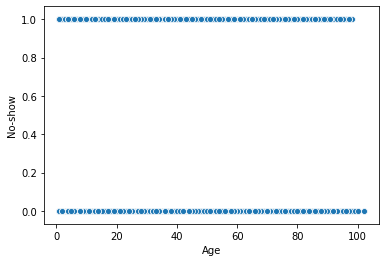

In [11]:
variables = ['Age','Gender','Scholarship','Hypertension','Diabetes','Alcoholism','Handicap','SMS_received','No-show']
plot_data = df.select(variables).toPandas()
sns.scatterplot(data=plot_data, x='Age', y='No-show');

This plot doesn't look paritcularly interesting. Let's look at other variables and see if they are correlated with **'No-show'**.

In [12]:
plot_data.corr()[8:9]

,Age,Gender,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
No-show,-0.067205,-0.003205,0.029387,-0.037248,-0.015916,-0.000508,-0.006698,0.127305,1.0


Visualize the correlation table.

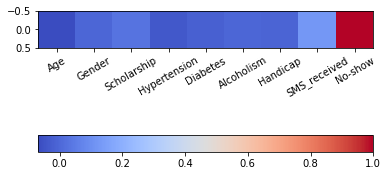

In [13]:
plt.imshow(plot_data.corr()[8:9], cmap='coolwarm')
plt.colorbar(orientation='horizontal', pad=0.4)
plt.xticks(range(9), variables)
plt.xticks(rotation=30)
plt.show()

Our predictors are weakly correlated with the target varaible. Maybe we need to create some more useful features!

### Feature Engineering

**1.** We have columns 'ScheduledDay' and 'AppointmentDay', it is likely that the time difference between these columns, i.e. **waiting time**, will be more predictive of no-show. Therefore, we will create a new feature **WaitingDay**.

In [14]:
from pyspark.sql.functions import datediff, col

df = df.withColumn('WaitingDay', datediff(col('AppointmentDay'),col('ScheduledDay')))
df = df.filter(df.WaitingDay >= 0) # Remove invalid values

Look at the Pearson Correlation between our new feature and target variable.

In [15]:
print('Pearson Correlation coefficients:\nWaitingDay~NoShow: {:.4f}'.format(df.stat.corr('WaitingDay','No-show')))

Pearson Correlation coefficients:
WaitingDay~NoShow: 0.0611


**2.** There may be an interaction effect between **WaitingDay** and **SMS_received**, such that getting a SMS notification will minimize the effect of **WaitingDay** on **No-show**. We will create a new variable **SMStime**.

In [16]:
df = df.withColumn('SMStime', (1-df.SMS_received) * df.WaitingDay)

**3.** Day of the week of the appointment may be a good predictor. We will create a new feature **DayofWeek**, such that 'Sunday' = 0, 'Monday' = 1, etc.

In [17]:
from pyspark.sql.functions import dayofweek

df = df.withColumn('AppointmentDayofWeek', dayofweek('AppointmentDay'))

Look at the distribution of our new feature.

AppointmentDayofWeek  No-show
1                     0           9880
                      1           4240
2                     0          11397
                      1           4604
3                     0          12058
                      1           4493
4                     0           7931
                      1           2999
5                     0           8605
                      1           3586
6                     0             22
                      1              9
dtype: int64


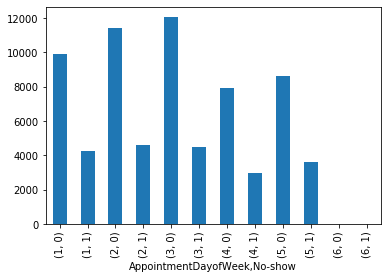

In [18]:
day_data = df.select('AppointmentDayofWeek','No-show').toPandas()
grouped_data = day_data.groupby(['AppointmentDayofWeek','No-show']).size()
print(grouped_data);
grouped_data.plot.bar();

Transform the feature **DayofWeek** from integers to categorical variables.

In [19]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCols=['AppointmentDayofWeek'],outputCols=['AppointmentDayofWeek_Vec'])
model = encoder.fit(df)
df = model.transform(df)

**4.** Month of the appointment day and day/month of scheduled day may also be good predictors. We will create new features **AppointmentMonth**, **ScheduleDay**, and **ScheduleMonth**.

In [20]:
from pyspark.sql.functions import month

df = df.withColumn('ScheduledDayofWeek', dayofweek('ScheduledDay'))
df = df.withColumn('ScheduledMonth', month('ScheduledDay'))
df = df.withColumn('AppointmentMonth', month('AppointmentDay'))

encoder = OneHotEncoder(inputCols=['ScheduledDayofWeek','ScheduledMonth','AppointmentMonth'],
                        outputCols=['ScheduledDayofWeek_Vec','ScheduledMonth_Vec','AppointmentMonth_Vec'])
model = encoder.fit(df)
df = model.transform(df)

**5.** Patients may have unexpected weekend plans so the No-show rate may be difffernt from that on weekdays. Therefore, we will create a new feature **Weekend**.

In [21]:
df = df.withColumn('Weekend', when(df['AppointmentDayofWeek'] == 0, 1).otherwise(0))

**6.** As we have small number of patients with hypertension, diabetes, and alcoholism, grouping these variables together may be beneficial to represent general **Health**. Besides, we can recode **Handicap** variable into mild (0) and severe (1) conditions.

In [22]:
df = df.withColumn('Health', df.Hypertension + df.Diabetes + df.Alcoholism)
df = df.withColumn('Handicap', when(df['Handicap'] <= 1, 0).otherwise(1))

**7.** One-hot encdoing categorical feature **Neighbourhood**. 

In [23]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol='Neighbourhood', outputCol="Neighbourhood_Int", stringOrderType="frequencyDesc")
model = stringIndexer.fit(df)
df = model.transform(df)

encoder = OneHotEncoder(inputCols=['Neighbourhood_Int'],outputCols=['Neighbourhood_Vec'])
model = encoder.fit(df)
df = model.transform(df)

### Prepare Data for ML Classification

Count the number of show/no-show in our cleaned dataset.

In [24]:
count = df.groupBy('No-show').count()
count.show()
count_array = count.collect()
print('Percent of Absence: {:.4f}'.format(count_array[0]['count']/(count_array[0]['count']+count_array[1]['count'])))

+-------+-----+
|No-show|count|
+-------+-----+
|      1|19931|
|      0|49893|
+-------+-----+

Percent of Absence: 0.2854


~28.5% of patients didn't show up. Although the distribution is not perfectly balanced, it is acceptable.

In [25]:
from pyspark.ml.feature import VectorAssembler

interested_features = ['Age','Gender','Scholarship','Health','Handicap','SMS_received','SMStime',
                       'WaitingDay','Neighbourhood_Vec','Weekend',
                       'AppointmentDayofWeek_Vec','AppointmentMonth_Vec',
                       'ScheduledDayofWeek_Vec','ScheduledMonth_Vec']
assembler = VectorAssembler(inputCols=interested_features, outputCol='features')
df_ml = assembler.transform(df)
df_ml = df_ml.select(['features', 'No-show'])

Split the dataframe into training and testing datasets.

In [26]:
splits = df_ml.randomSplit([0.7, 0.3])
unstandardized_train_df = splits[0]
unstandardized_test_df = splits[1]
print('Number of rows in the Training set: {}'.format(unstandardized_train_df.count()))
print('Number of rows in the Testing set: {}'.format(unstandardized_test_df.count()))

Number of rows in the Training set: 48806
Number of rows in the Testing set: 21018


Standardize the features to prepare data for modelling.

In [27]:
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler()
standardScaler.setInputCol("features")
standardScaler.setOutputCol("scaled_features")
model = standardScaler.fit(unstandardized_train_df)
train_df = model.transform(unstandardized_train_df)
test_df = model.transform(unstandardized_test_df)

### Build Machine Learning Models

Define model evaluator which evaluates performance based on accuracy.

In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='No-show', metricName='accuracy')

### 1. Logistic Regression

In [29]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'No-show', maxIter=100)
lrModel = lr.fit(train_df)
lr_predictions = lrModel.transform(test_df)
print('Logistic Regression Accuracy:', evaluator.evaluate(lr_predictions))

Logistic Regression Accuracy: 0.717765724616995


### 2. Gradient-boosted Tree 

In [30]:
from pyspark.ml.classification import GBTClassifier

gb = GBTClassifier(labelCol = 'No-show', featuresCol = 'scaled_features')
gbModel = gb.fit(train_df)
gb_predictions = gbModel.transform(test_df)
print('Gradient-boosted Tree Accuracy:', evaluator.evaluate(gb_predictions))

Gradient-boosted Tree Accuracy: 0.7180987724807308


### 3. Random Forest

In [31]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='No-show', featuresCol='scaled_features',maxDepth=5)
rfModel = rf.fit(train_df)
rf_predictions = rfModel.transform(test_df)
print('Random Forest classifier Accuracy:', evaluator.evaluate(rf_predictions))

Random Forest classifier Accuracy: 0.7170996288895233


### Conclusion

The three models we have tested here have accuracy around 71.8%. In comparison, a dummy classifier that assumes all patients will show up will be (1 -0.2854)\*100 = 71.46% correct. Therefore, the current models are not predictive of No-show. Why?

It is possible that these models require finer tuning of hyperparameters or more exhaustive feature engineering (e.g. polynomials). In addition, most of the raw predictors provided in these datasets are weakly correlated with the target variable (r < 0.01), and the dataset may benefit from including other information, such as type of appointment (e.g. routine, consultation, surgery), referrals and departments (e.g. concology, neurology, cardiovascular).

Nevertheless, this projects provide me an opportunity to test out PySpark functions and libraries, demonstrating the power of distributed processing to clean up, process and analyze large dataset.

